<a href="https://colab.research.google.com/github/mmendez1012/Sistemas_inteligentes_Javeriana/blob/main/Aplicaci%C3%B3n_RN_Sistemas_Inteligentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#% cd sample_data/
#! ls -l

In [ ]:
 pip install Keras-Applications

     |████████████████████████████████| 50 kB 2.7 MB/s 


# Importación de librerias

In [1]:
#Librerias
import cv2
from google.colab.patches import cv2_imshow
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

#Otras librerias necesarias de keras

from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
#from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

%tensorflow_version 2.x
import tensorflow as tf
print("version de Tensorflow:"+tf.__version__)

version de Tensorflow:2.6.0


#Carga de los datos

**ACCESO A GOOGLE DRIVE para Cargar Data**

In [ ]:
#Montar google drive
from google.colab import drive
drive.mount('/content/drive')

% cd /content/drive/MyDrive/Colab Notebooks
#Acá debemos cargar los archivos de imagenes y etiquetas en google drive

#Cargar etiquetas
lab=np.load('labels.npy')

#Cargar imagenes
img=np.load('Imagenes_gris_240.npy')


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


Aqui validamos la usabilidad del GPU en el entorno

In [ ]:
nombre_gpu = tf.test.gpu_device_name()
if nombre_gpu != '/device:GPU:0':
  raise SystemError("GPU no encontrada")
print('GPU encontrada: {}'.format(nombre_gpu))

GPU encontrada: /device:GPU:0


In [3]:
img=np.load('/content/Imagenes_gris_240.npy')
lab=np.load('/content/labels.npy')

In [ ]:
img[1]

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [120, 121, 122, ..., 153, 163, 173],
       [120, 121, 122, ..., 151, 164, 174],
       [124, 123, 122, ..., 144, 146, 150]], dtype=uint8)

In [ ]:
img.shape

(2000, 240, 240)

In [ ]:
lab.shape

(2000, 1)

In [ ]:
img.shape

(2000, 240, 240)

# Entendimiento de los datos

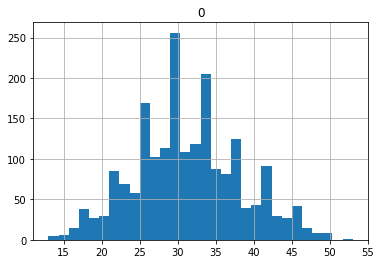

In [ ]:
label=pd.DataFrame(lab)
label
label.hist(bins=30);

Podemos ver que la distribución de los conteos de objetos tienen una similitud a una normal, a continuación vemos los parametros de esta

In [ ]:
label.describe()

,0
count,2000.000000
mean,31.157500
std,6.945417
min,13.000000
25%,26.000000
50%,31.000000
75%,36.000000
max,53.000000


La media y la mediana son cercanas por lo que se puede esperar que los datos se distribuyan de manera normal con media de 30 personas por imagen.

**Ver una imagen**

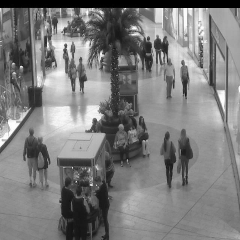

In [ ]:
img_gris = cv2.resize(img[1390], (240,240))
cv2_imshow(img_gris)

In [ ]:
img[90].shape

(240, 240)

Realizamos una pequeña visualización del dataset

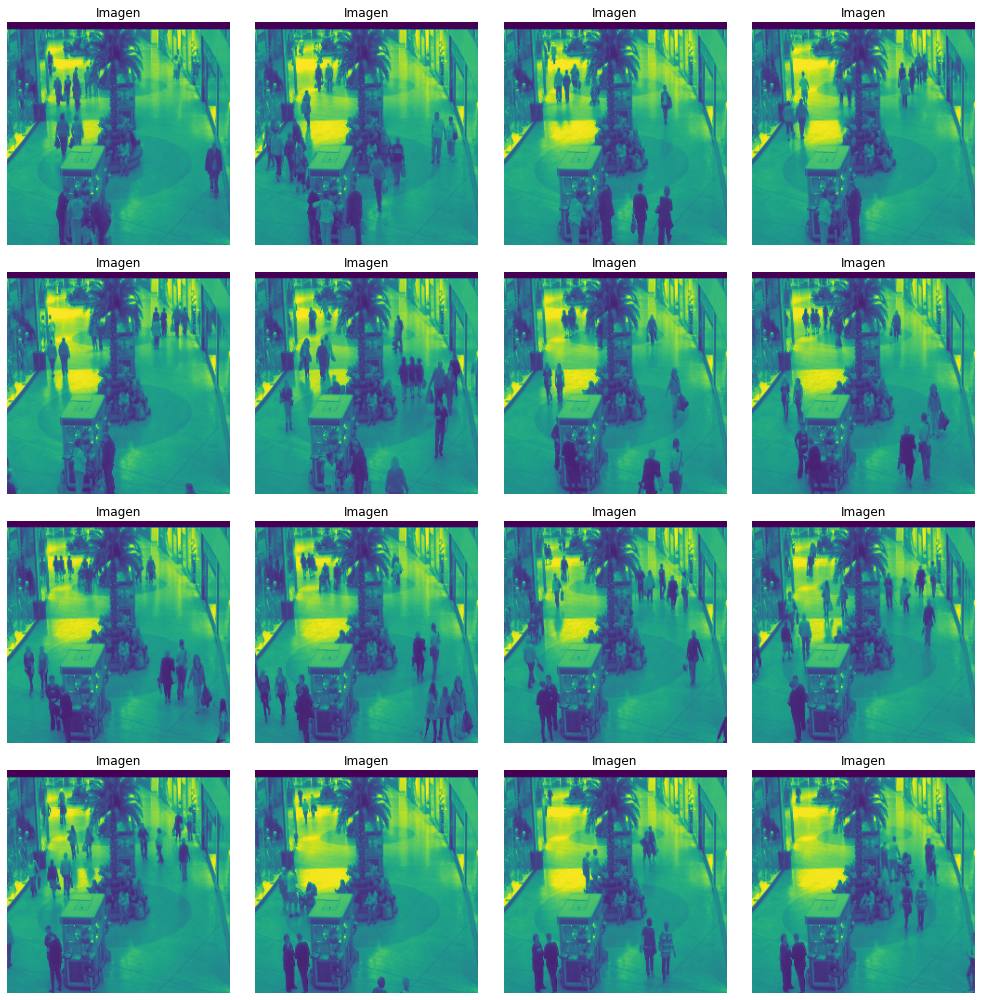

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(14, 14))
axes = axes.flatten()
for i in range(16):
    ax = axes[i]
    ax.imshow(img[i+89])
    ax.axis('off')
    ax.set_title("Imagen")
plt.tight_layout()
plt.show()

# Procesamiento de los datos

Se separa en validación y prueba

In [4]:

#res = cv2.resize(img, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
x_train, x_test, y_train, y_test = train_test_split(img, lab, test_size=0.2)
print(x_train.shape)
print(x_test.shape)

(1600, 240, 240)
(400, 240, 240)


Se aumenta una dimensión del objeto matricial

In [5]:
#480-640
train_X = x_train.reshape(-1, 240,240, 1)
test_X = x_test.reshape(-1, 240,240, 1)
train_X.shape, test_X.shape

((1600, 240, 240, 1), (400, 240, 240, 1))

Se normalizan los pixeles para poder mejorar el proceso de optimización

In [6]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

# Contrucción del modelo

Realizamos un primer acercamiento construyendo una primera red

In [ ]:
# create model 
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(64, (3,3), input_shape=(240,240,1), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)  
])

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 119, 119, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 117, 117, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 58, 58, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 430592)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               5

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Usamos un Callback para poder tunear el learning rate

In [ ]:
lr_monitor = tf.keras.callbacks.LearningRateScheduler(
                lambda epochs : 1e-8 * 10 ** (epochs/5))

In [ ]:
tf.config.run_functions_eagerly(True)

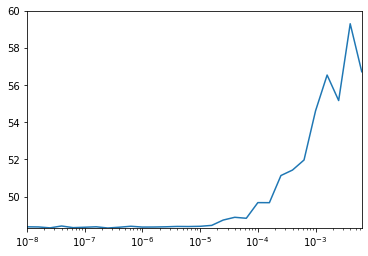

In [ ]:
# plot mae
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([np.min(history.history['lr']), np.max(history.history['lr']), np.min(history.history['loss']), 60])
plt.show()

Observamos que se presenta convergencia alrededor de 10-4



## Entrenamiento del primer modelo



In [ ]:
history = model.fit(train_X, y_train, validation_data=(test_X, y_test), epochs=30, batch_size=4, callbacks=[lr_monitor])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
400/400 [==============================] - 49s 122ms/step - loss: 48.3830 - mae: 5.5651 - val_loss: 47.6809 - val_mae: 5.3987
Epoch 2/30
400/400 [==============================] - 49s 121ms/step - loss: 48.3760 - mae: 5.5661 - val_loss: 47.6822 - val_mae: 5.3989
Epoch 3/30
400/400 [==============================] - 48s 120ms/step - loss: 48.3271 - mae: 5.5619 - val_loss: 47.6850 - val_mae: 5.3994
Epoch 4/30
400/400 [==============================] - 48s 121ms/step - loss: 48.4269 - mae: 5.5680 - val_loss: 47.6890 - val_mae: 5.4001
Epoch 5/30
400/400 [==============================] - 48s 121ms/step - loss: 48.3387 - mae: 5.5620 - val_loss: 47.6943 - val_mae: 5.4009
Epoch 6/30
400/400 [==============================] - 49s 122ms/step - loss: 48.3602 - mae: 5.5642 - val_loss: 47.7039 - val_mae: 5.4025
Epoch 7/30
400/400 [==============================] - 49s 122ms/step - loss: 48.3840 - mae: 5.5648 - val_loss: 47.7178 - val_mae: 5.4046
Epoch 8/30
400/400 [=====================

## Observamos los resultados

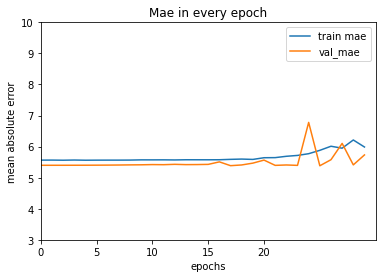

In [ ]:
# plot mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['train mae', 'val_mae'])
plt.ylim(3, 10)
plt.xlim(10, 30)

plt.xticks(np.arange(0,25, 5))

plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.title('Mae in every epoch')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_X, y_test, batch_size=128)
print("test mse:", results[1])

Evaluate on test data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 2s 380ms/step - loss: 55.2224 - mae: 5.7325
test mse: 5.732499599456787


#Pruebas con diferentes arquitecturas


In [ ]:
#### Prueba Dave
# create model 
#307200
#480, 640
model1 = tf.keras.Sequential([                      
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(240,240,1), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation= 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation= 'relu'),
    tf.keras.layers.Dense(1)

])


model1.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['mae'])
model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 238, 238, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 119, 119, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 117, 117, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history1 = model1.fit(train_X, y_train, validation_data=(test_X, y_test), epochs=30, batch_size=4, callbacks=[lr_monitor])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/30
400/400 [==============================] - 21s 52ms/step - loss: 587.0464 - mae: 21.4276 - val_loss: 427.5741 - val_mae: 19.3215
Epoch 2/30
400/400 [==============================] - 20s 49ms/step - loss: 534.6617 - mae: 20.4303 - val_loss: 354.8559 - val_mae: 17.3334
Epoch 3/30
400/400 [==============================] - 21s 51ms/step - loss: 448.0695 - mae: 18.2897 - val_loss: 262.4871 - val_mae: 14.4530
Epoch 4/30
400/400 [==============================] - 21s 52ms/step - loss: 338.7028 - mae: 15.4343 - val_loss: 163.0433 - val_mae: 10.7631
Epoch 5/30
400/400 [==============================] - 21s 53ms/step - loss: 241.8071 - mae: 12.7509 - val_loss: 80.7369 - val_mae: 7.0851
Epoch 6/30
400/400 [==============================] - 21s 52ms/step - loss: 166.5513 - mae: 10.2015 - val_loss: 54.1387 - val_mae: 5.9672
Epoch 7/30
400/400 [==============================] - 20s 50ms/step - loss: 124.8420 - mae: 8.9192 - val_loss: 61.3745 - val_mae: 6.5806
Epoch 8/30
400/400 [=======

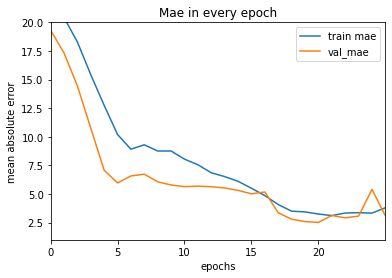

In [ ]:
# plot mae
plt.plot(history1.history['mae'])
plt.plot(history1.history['val_mae'])
plt.legend(['train mae', 'val_mae'])
plt.ylim(1, 20)
plt.xlim(0, 25)

plt.xticks(np.arange(0,25, 5))

plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.title('Mae in every epoch')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate(test_X, y_test, batch_size=128)
print("test mse:", results[1])

Evaluate on test data


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


4/4 [==============================] - 1s 191ms/step - loss: 51.8327 - mae: 5.9572
test mse: 5.957174777984619


## Construcción de una red RestNet50

In [ ]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [ ]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 200 # 200
USE_AUGMENTATION = True
NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = train_X.shape[3]

# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = True

# Model version
# Orig paper: version = 1 (ResNet v1), 
# Improved ResNet: version = 2 
# (ResNet v2)
VERSION = 1

# Computed depth from supplied model parameter n
if VERSION == 1:
    DEPTH = COLORS * 6 + 2
elif version == 2:
    DEPTH = COLORS * 9 + 2

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(1)(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Input image dimensions.
input_shape = train_X.shape[1:]
input_shape

(240, 240, 1)

In [ ]:

# Create the neural network
if VERSION == 2:
    model = resnet_v2(input_shape=input_shape, depth=DEPTH)
else:
    model = resnet_v1(input_shape=input_shape, depth=DEPTH)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 1) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 240, 240, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 240, 240, 16) 64          conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 16) 0           batch_normalization[0][0]        
________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not USE_AUGMENTATION:
    print('Not using data augmentation.')
    model.fit(train_X, y_train,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(test_X, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation 
        # (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train_X)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train_X, y_train, 
                        batch_size=BATCH_SIZE),
                        validation_data=(test_X, y_test),
                        epochs=EPOCHS, verbose=0, workers=1,
                        callbacks=callbacks, 
                        use_multiprocessing=False)
    
elapsed_time = time.time() - start_time
print("Elapsed time: {}".format((elapsed_time)))

Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning rate:  0.001
Learning r

NameError: ignored

In [ ]:
# Score trained model.
scores = model.evaluate(test_X, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test mse:', scores[1])

 1/13 [=>............................] - ETA: 1s - loss: nan - accuracy: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


13/13 [==============================] - 2s 129ms/step - loss: nan - accuracy: 0.0000e+00
Test loss: nan
Test mse: 0.0


La ResNet presento loss nan lo que puede indicar el efecto desvanecimiento del gradiente

## Construcción de la VGG16

Intentamos construir la VGG16 la cual dio buenos resultados en el estado del arte

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
model3 = VGG16(include_top=True, weights='imagenet',input_shape=input_shape)

In [ ]:
model3.compile(loss=tf.keras.losses.MeanSquaredError()',
              optimizer=Adam(lr=1e-6),
              metrics=['accuracy'])
model3.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator

model = Sequential()
model.add(Conv2D(input_shape=(240,240,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(1))

In [ ]:

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(lr=1e-6), metrics=['mae'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 240, 240, 64)      640       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 240, 240, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 120, 120, 128)     73856     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 120, 120, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 60, 60, 256)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(train_X, y_train, validation_data=(test_X, y_test), epochs=30, batch_size=32)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["acc"])
plt.plot(hist.history['val_mse'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_mse'])
plt.title("model mse")
plt.ylabel("mse")
plt.xlabel("Epoch")
plt.legend(["mse","Validation mse","loss","Validation Loss"])
plt.show()

In [ ]:
scores = model.evaluate(test_X, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test mse:', scores[1])

**Tuning de hiperparámetros para modelo vgg16**

In [ ]:
!pip install keras-tuner
from tensorflow import keras

In [ ]:
def buil_model(hp):
  model = keras.Sequential([
    keras.layers.Conv2D(input_shape=(240,240,1),
                    filters=hp.Int('conv_1_filter',min_value=64,max_value=128,step=32),
                    kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_2_filter',min_value=64,max_value=128,step=32),
                    kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Int('conv_3_filter',min_value=128,max_value=256,step=64),
                    kernel_size=hp.Choice('conv_3_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_4_filter',min_value=128,max_value=256,step=64),
                    kernel_size=hp.Choice('conv_4_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Int('conv_5_filter',min_value=256,max_value=512,step=128),
                    kernel_size=hp.Choice('conv_5_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_6_filter',min_value=256,max_value=512,step=128),
                    kernel_size=hp.Choice('conv_6_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_7_filter',min_value=256,max_value=512,step=128),
                    kernel_size=hp.Choice('conv_7_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Int('conv_8_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_8_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_9_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_9_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_10_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_10_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Int('conv_11_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_11_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_12_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_12_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Int('conv_13_filter',min_value=512,max_value=1024,step=256),
                    kernel_size=hp.Choice('conv_13_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=hp.Int('dense_1_units',min_value=3072,max_value=5120),
                   activation="relu"),
    keras.layers.Dense(units=hp.Int('dense_2_units',min_value=3072,max_value=5120),
                   activation="relu"),
    keras.layers.Dense(1)                      
                            
  ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-6,1e-5,1e-4])), 
                loss=keras.losses.MeanSquaredError(),
                metrics=['mae'])
  
  return model


In [ ]:
def buil_model(hp):
  model = keras.Sequential([
    keras.layers.Conv2D(input_shape=(240,240,1),
                    filters=hp.Choice('conv_1_filter',values=list(range(64,129,32))),
                    kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_2_filter',values=list(range(64,129,32))),
                    kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Choice('conv_3_filter',values=list(range(128,257,64))),
                    kernel_size=hp.Choice('conv_3_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_4_filter',values=list(range(128,257,64))),
                    kernel_size=hp.Choice('conv_4_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Choice('conv_5_filter',values=list(range(256,513,128))),
                    kernel_size=hp.Choice('conv_5_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_6_filter',values=list(range(256,513,128))),
                    kernel_size=hp.Choice('conv_6_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_7_filter',values=list(range(256,513,128))),
                    kernel_size=hp.Choice('conv_7_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Choice('conv_8_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_8_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_9_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_9_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_10_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_10_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Conv2D(filters=hp.Choice('conv_11_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_11_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_12_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_12_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.Conv2D(filters=hp.Choice('conv_13_filter',values=list(range(512,1025,256))),
                    kernel_size=hp.Choice('conv_13_kernel',values=[3,5]),
                    padding="same", 
                    activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=hp.Choice('dense_1_units',values=[4096,5120]),
                   activation="relu"),
    keras.layers.Dense(units=hp.Choice('dense_2_units',values=[4096,5120]),
                   activation="relu"),
    keras.layers.Dense(1)                      
                            
  ])
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-5,1e-4])), 
                loss=keras.losses.MeanSquaredError(),
                metrics=['mae'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [ ]:
tuner_search=RandomSearch(buil_model,
                          objective="val_mae",
                          seed=1,
                          max_trials=30, #número de configuraciones
                          directory="output_experiment",
                          project_name="cnn_crowd"
                          )

INFO:tensorflow:Reloading Oracle from existing project output_experiment/cnn_crowd/oracle.json


In [ ]:
tuner_search.search(train_X, y_train,
                    epochs=2,
                    validation_split=0.2)

El gasto computacional de la VGG16 fue muy alto para la complejidad del problema

# Protocolo experimental: Cuadro Latino


Aqui se proceden a realizar las diferentes arquitecturas expuestas en el documento entregable, para determiner cual es la mejor configuración de red

In [7]:
# create model 
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(128, (3,3), input_shape=(240,240,1), activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1)  
    
])

model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.SGD(lr=1e-4), metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 238, 238, 128)     1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 236, 236, 128)     147584    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 234, 234, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 117, 117, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 115, 115, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 113, 113, 128)     147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 111, 111, 128)     1

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
history1 = model.fit(train_X, y_train, validation_data=(test_X, y_test), epochs=15, batch_size=4)

Epoch 1/15
400/400 [==============================] - 204s 418ms/step - loss: 462.5822 - mae: 16.5150 - val_loss: 45.3154 - val_mae: 5.3346
Epoch 2/15
400/400 [==============================] - 173s 433ms/step - loss: 58.8640 - mae: 6.0849 - val_loss: 46.5617 - val_mae: 5.4354
Epoch 3/15
400/400 [==============================] - 167s 416ms/step - loss: 58.2498 - mae: 6.0967 - val_loss: 46.2519 - val_mae: 5.4191
Epoch 4/15
400/400 [==============================] - 173s 433ms/step - loss: 58.6703 - mae: 6.1477 - val_loss: 48.0447 - val_mae: 5.4466
Epoch 5/15
400/400 [==============================] - 173s 432ms/step - loss: 56.2145 - mae: 5.9575 - val_loss: 47.7969 - val_mae: 5.4374
Epoch 6/15
400/400 [==============================] - 166s 416ms/step - loss: 58.2233 - mae: 6.0936 - val_loss: 47.6905 - val_mae: 5.5388
Epoch 7/15
400/400 [==============================] - 167s 417ms/step - loss: 58.6782 - mae: 6.1585 - val_loss: 52.4306 - val_mae: 5.6953
Epoch 8/15
400/400 [============

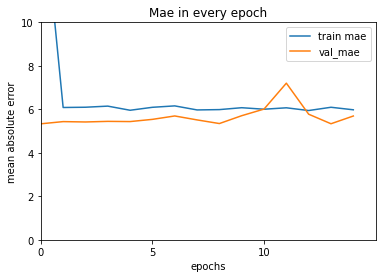

In [10]:
# plot mae
plt.plot(history1.history['mae'])
plt.plot(history1.history['val_mae'])
plt.legend(['train mae', 'val_mae'])
plt.ylim(0, 10)
plt.xlim(10, 15)

plt.xticks(np.arange(0,15, 5))

plt.xlabel('epochs')
plt.ylabel('mean absolute error')
plt.title('Mae in every epoch')
plt.show()

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_X, y_test, batch_size=4)
print("test mse:", results[1])

Evaluate on test data
100/100 [==============================] - 3s 30ms/step - loss: 23.1482 - mae: 3.8893
test mse: 3.8893117904663086


In [12]:
from keras.utils.vis_utils import plot_model

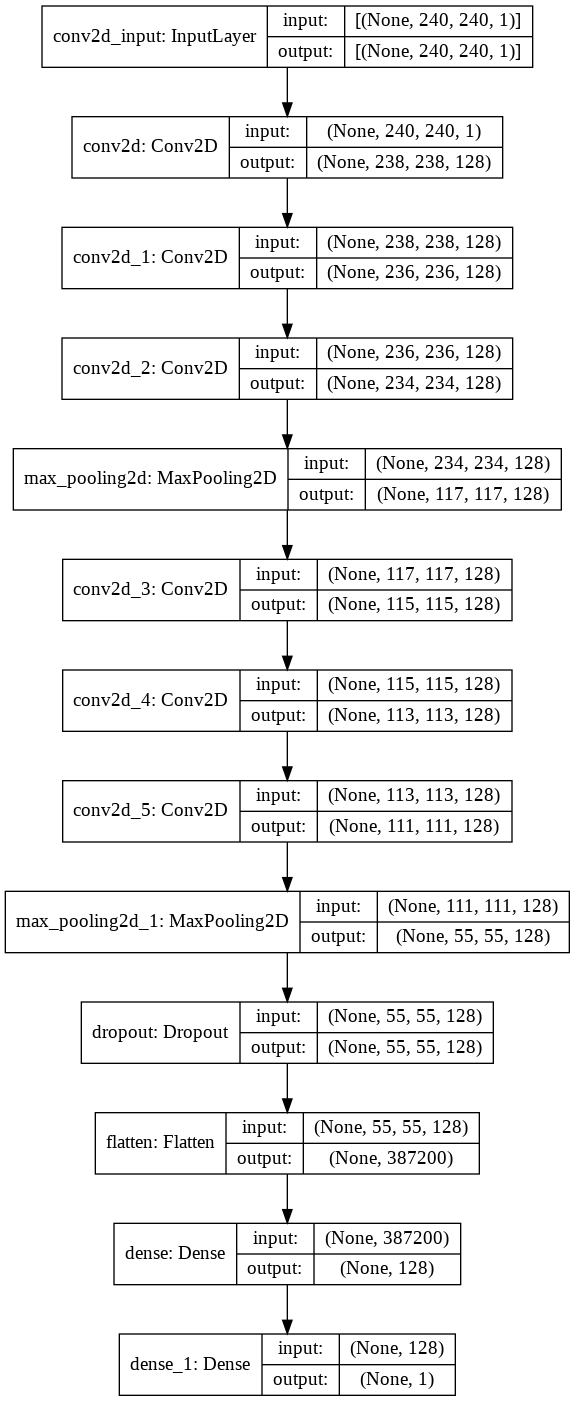

In [13]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)